In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.vision.gan import *

In [0]:
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [0]:
path = untar_data(URLs.COCO_SAMPLE)

In [0]:
path

PosixPath('/root/.fastai/data/coco_sample')

In [0]:
ptrain = path/'train_sample'

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/coco_sample/train_sample'),
 PosixPath('/root/.fastai/data/coco_sample/annotations')]

In [0]:
il = ImageList.from_folder(ptrain)

In [0]:
il

ImageList (21837 items)
Image (3, 604, 640),Image (3, 427, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 403, 640)
Path: /root/.fastai/data/coco_sample/train_sample

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(ptrain)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    img = img.resize(size, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest)

In [0]:
sets = [(path/'128',(128,128))]
for p,s in sets:
  if not p.exists():
    parallel(partial(resize_one, path = p, size = s), il.items)

In [0]:
pl = path/'128'

In [0]:
src = ImageImageList.from_folder(pl).split_by_rand_pct(0.05, seed = 42)

In [0]:
def get_data(bs):
  data = (src.label_from_func(lambda x: pl/x.name).databunch(bs = bs).normalize(imagenet_stats, do_y = True))
  data.c = 3
  return data

In [0]:
data = get_data(3)

In [0]:
data

ImageDataBunch;

Train: LabelList (20746 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/coco_sample/128;

Valid: LabelList (1091 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/coco_sample/128;

Test: None

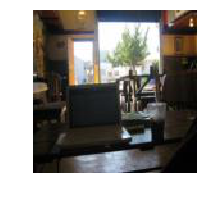

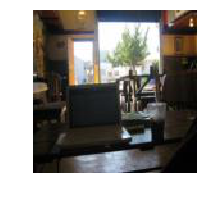

In [0]:
data.train_ds[3][0].show()
data.train_ds[3][1].show()

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 101MB/s]


In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [0]:
blocks

[5, 12, 22, 32, 42]

In [0]:
base_loss = F.mse_loss

In [0]:
def gram_matrix(x):
  n,c,h,w = x.size()
  x = x.view(n,c,-1)
  return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
con_blocks = blocks[1]
style_blocks = blocks[:-1]

In [0]:
style_blocks

[5, 12, 22, 32]

In [0]:
!ls /content/drive/Content

coco_tiny  data_save.pkl		  IMG_20190802_142157_Bokeh.jpg  sj.jpg
data	   IMG_20190802_142005_Bokeh.jpg  models			 stimg
data.pkl   IMG_20190802_142017_Bokeh.jpg  portrait.jpg			 yo.pth


In [0]:
sty_img = open_image('.../sj.jpg')

FileNotFoundError: ignored

In [0]:
sty_img.resize(256)

NameError: ignored

In [0]:
sty_img.shape

torch.Size([3, 256, 256])

In [0]:
stdata = sty_img.data.expand(1,3,256,256).cuda()

In [0]:
stdata.shape

torch.Size([1, 3, 256, 256])

In [0]:
class Featureloss(nn.Module):
  def __init__(self,model,style_blocks,con_blocks,layer_wgts,stim_data):
    super().__init__()
    self.model = model
    self.stblocks = style_blocks
    self.ctblocks = con_blocks
    self.hooks1 = hook_outputs([self.model[i] for i in self.stblocks],detach = False)
    self.hooks2 = hook_output(self.model[self.ctblocks], detach = False)
    self.lwght = layer_wgts
    self.stim = stim_data
    self.metric_names = ['content_loss', 'style_loss']

  def make_features(self,x,clone = False,typ = 'content'):
    self.model(x)
    if typ == 'content':
      return [(o.clone() if clone else o) for o in self.hooks2.stored]
    else:
      return [(o.clone() if clone else o) for o in self.hooks1.stored]

  def forward(self,input,target):
    ctf = self.make_features(target,clone = True)
    incf = self.make_features(input)
    insf = self.make_features(input,typ = 'style')
    stf = self.make_features(self.stim, typ = 'style') 
    a,c,h,w = self.stim.shape  
    self.ctloss = base_loss(ctf[0],incf[0])/(c*h*w)
    self.stloss = [base_loss(gram_matrix(fin),gram_matrix(fou))*w for fin,fou,w in zip(insf,stf,self.lwght)]
    self.metrics = dict(zip(self.metric_names, [self.ctloss, sum(self.stloss)]))
    return self.ctloss + sum(self.stloss)   

  def __del__(self):
    self.hooks1.remove()
    self.hooks2.remove()         

In [0]:
loss_func = Featureloss(vgg_m, style_blocks,con_blocks,[100,200,30,2],stdata)

In [0]:
learn = unet_learner(data,arch = models.resnet34,loss_func = loss_func,blur = True,norm_type=NormType.Weight,callback_fns=LossMetrics)

In [0]:
learn.load('learn')

Learner(data=ImageDataBunch;

Train: LabelList (20746 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /root/.fastai/data/coco_sample/256;

Valid: LabelList (1091 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /root/.fastai/data/coco_sample/256;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mo

In [0]:
gc.collect()

140

In [0]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 512, 512

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


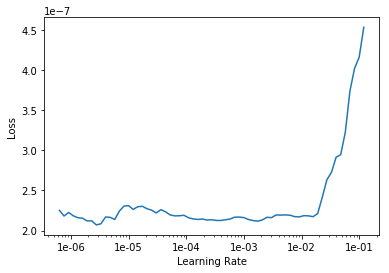

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1,slice(1e-05,1e-03/5))

epoch,train_loss,valid_loss,content_loss,style_loss,time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([1, 512, 512

In [0]:
learn.save('learn')

In [0]:
tim = open_image('.../portrait.jpg')

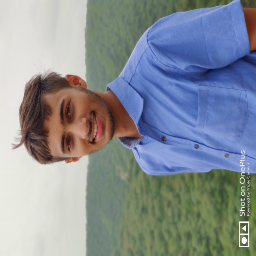

In [0]:
tim.resize(256)

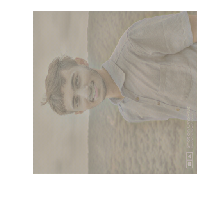

In [0]:
learn.predict(tim)[0].show()